# Full prediction pipeline using YOLOv3 and Google Vision API

In [3]:
import os
import sys
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.insert(0, "../scripts")
from prediction_utils import *

In [4]:
# add Cloud Vision API key to environment
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../ServiceAccountToken_VisionAPI.json'

In [7]:
src_path = os.path.join('..', 'YOLOv3', 'TrainYourOwnYOLO', "2_Training", "src")
utils_path = os.path.join('..', 'YOLOv3', 'TrainYourOwnYOLO', "Utils")

sys.path.append(src_path)
sys.path.append(utils_path)

# more imports here
from keras_yolo3.yolo import YOLO
from utils import detect_object

# Set up folder names for default values
data_folder = os.path.join('..','YOLOv3','TrainYourOwnYOLO', "Data")
image_folder = os.path.join(data_folder, "Source_Images")
image_test_folder = os.path.join(image_folder, "Test_Images")
model_folder = os.path.join(data_folder, "Model_Weights")
model_weights = os.path.join(model_folder, "trained_weights_final_ck2000.h5")
model_classes = os.path.join(model_folder, "data_classes.txt")
anchors_path = os.path.join(src_path, "keras_yolo3", "model_data", "yolo_anchors.txt")

#FLAGS = None

# define YOLO detector
yolo = YOLO(
    **{
        "model_path": model_weights,
        "anchors_path": anchors_path,
        "classes_path": model_classes,
        "score": 0.25,
        "gpu_num": 1,
        "model_image_size": (416, 416),
    }
)

W0611 07:11:36.671668 139865645385472 module_wrapper.py:139] From /home/perry/anaconda3/envs/cerealkiller2_YOLO_py37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0611 07:11:36.672602 139865645385472 module_wrapper.py:139] From /home/perry/anaconda3/envs/cerealkiller2_YOLO_py37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0611 07:11:36.673343 139865645385472 module_wrapper.py:139] From /home/perry/anaconda3/envs/cerealkiller2_YOLO_py37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0611 07:11:36.695206 139865645385472 module_wrapper.py:139] From /home/perry/anaconda3/envs/cerealkiller2_YOLO_py37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.p

../YOLOv3/TrainYourOwnYOLO/Data/Model_Weights/trained_weights_final_ck2000.h5 model, anchors, and classes loaded in 7.76sec.


In [9]:
# Get cereal info from DB
conn =  connect_to_db()
s = 'select * from cereals'
df = pd.read_sql(s, connect_to_db())

# Load image
img_fname = os.path.join('..', 'data', 'real_box_shelves', 'Walgreens-cereal-4.jpg')
img = Image.open(img_fname).convert("RGB")
new_img = copy.deepcopy(img)

# Run YOLO detector
YOLO_predictions, new_image = yolo.detect_image(new_img);

# Generate vertically-stacked image 
stacked_image, stacked_img_edges = generate_stacked_image(YOLO_predictions, img)

# Detect text with Cloud Vision API and parse results
OCR_words_all, OCR_vertices = Vision_API_OCR(stacked_image)
    
#for word, vertices in zip(OCR_words_all, OCR_vertices):
#    print(word, vertices)

(416, 416, 3)
Found 20 boxes for img
cereal_box 0.97 (660, 1) (752, 83)
cereal_box 0.98 (13, 0) (107, 92)
cereal_box 0.99 (305, 3) (396, 100)
cereal_box 1.00 (211, 292) (288, 407)
cereal_box 1.00 (641, 298) (738, 392)
cereal_box 1.00 (107, 2) (206, 91)
cereal_box 1.00 (453, 146) (558, 272)
cereal_box 1.00 (25, 299) (123, 411)
cereal_box 1.00 (706, 171) (755, 281)
cereal_box 1.00 (211, 3) (305, 98)
cereal_box 1.00 (368, 297) (443, 401)
cereal_box 1.00 (166, 138) (280, 278)
cereal_box 1.00 (621, 153) (703, 274)
cereal_box 1.00 (122, 309) (206, 409)
cereal_box 1.00 (445, 299) (517, 399)
cereal_box 1.00 (67, 133) (168, 278)
cereal_box 1.00 (399, 5) (490, 104)
cereal_box 1.00 (0, 122) (71, 278)
cereal_box 1.00 (369, 148) (451, 272)
cereal_box 1.00 (290, 295) (367, 408)
Time spent: 1.439sec


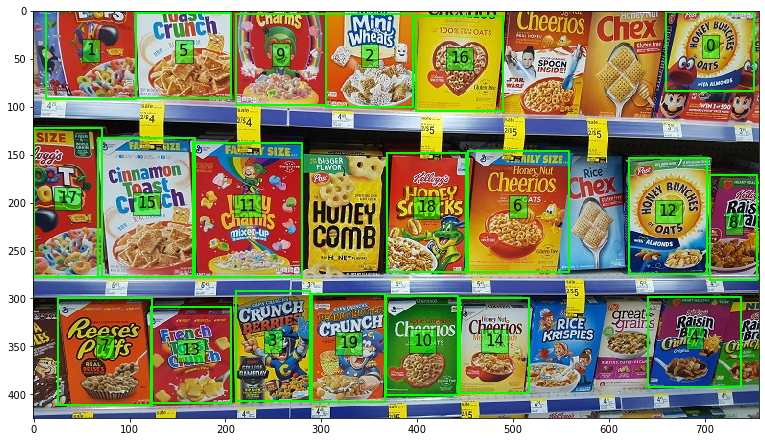

In [10]:
fig, ax = plt.subplots(1, figsize=(13,10))
ax.imshow(img);
for ix, box in enumerate(YOLO_predictions):
    ax.plot([box[0],box[2], box[2],box[0],box[0]], [box[1],box[1],box[3],box[3],box[1]], linewidth=2, color='lime')
    ax.text(np.mean([box[0], box[2]]), np.mean([box[1],box[3]]), str(ix), fontsize=15, bbox=dict(facecolor='lime', alpha=0.5), horizontalalignment='center')

In [11]:
# loop through detected boxes
results = []
for ix, box in enumerate(YOLO_predictions):
    # Find OCR text in this cereal box
    OCR_words = set()
    for word, vertices in zip(OCR_words_all, OCR_vertices):
        if (vertices['y'] > stacked_img_edges[ix]).all() & (vertices['y'] < stacked_img_edges[ix+1]).all():
            OCR_words.add(word)
    if len(OCR_words) > 0:
        # predict cereal
        label = get_cereal(df, OCR_words)
        # compile results in dictionary
        results.append({
            'OCR': OCR_words,
            'box': box[0:4],
            'label': label
        })
results

[{'OCR': {'bunce', 'c', 'oats', 'oney'},
  'box': [660, 1, 752, 83],
  'label': 'Honey Bunches of Oats'},
 {'OCR': {'wheas'}, 'box': [305, 3, 396, 100], 'label': 'Lucky Charms'},
 {'OCR': {'crunch', 'rerries'},
  'box': [211, 292, 288, 407],
  'label': "Cap'n Crunch"},
 {'OCR': {'raisin'}, 'box': [641, 298, 738, 392], 'label': 'Raisin Bran'},
 {'OCR': {'crunch'}, 'box': [107, 2, 206, 91], 'label': "Cap'n Crunch"},
 {'OCR': {'cheerios', 'honey,', 'ily', 'nut', 'oats', 'size'},
  'box': [453, 146, 558, 272],
  'label': 'Honey Nut Cheerios'},
 {'OCR': {'puffs', "reese's"},
  'box': [25, 299, 123, 411],
  'label': "Reese's Puffs"},
 {'OCR': {'cheerios', 'l.', 'oats', 'u'},
  'box': [368, 297, 443, 401],
  'label': 'Cheerios'},
 {'OCR': {'*', 'a', 'charms', 'e', 'fa', 'lucky', 'mixeb-up', 'size'},
  'box': [166, 138, 280, 278],
  'label': 'Lucky Charms'},
 {'OCR': {'*oats', 'almonds', 'gunche'},
  'box': [621, 153, 703, 274],
  'label': 'Lucky Charms'},
 {'OCR': {'french', 'ocrunch', 'toast

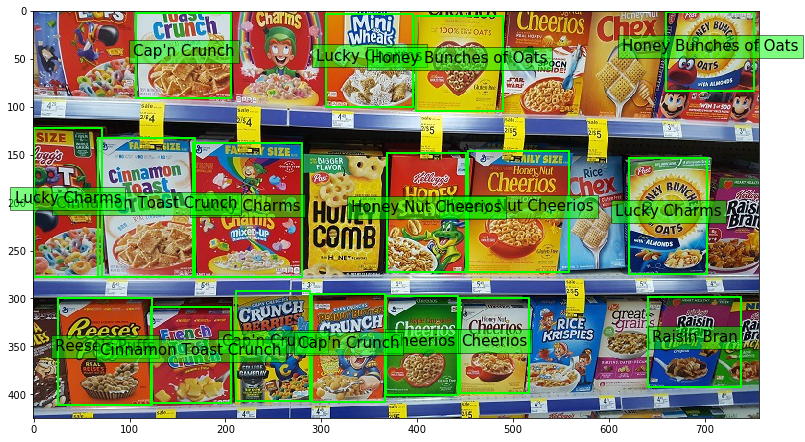

In [12]:
fig, ax = plt.subplots(1, figsize=(13,10))
ax.imshow(img);
for result in results:
    box = result['box']
    ax.plot([box[0],box[2], box[2],box[0],box[0]], [box[1],box[1],box[3],box[3],box[1]], linewidth=2, color='lime')
    ax.text(np.mean([box[0], box[2]]), np.mean([box[1],box[3]]), str(result['label']), fontsize=15, bbox=dict(facecolor='lime', alpha=0.5), horizontalalignment='center')